In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import KeyFunctions as me
import tensorflow as tf
RandState = 92

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

n = 4

In [2]:
from sklearn.model_selection import train_test_split

#Import Full Triclosan Dataset
df, labels = me.ConstructCombinedChlorDataset()

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()

#Augment Data to 4000 Spectra
X_tnAu, y_tnAu = me.AugmentData(X_tn, y_tn, 4000, df.columns.to_numpy(), False)

In [3]:
#Set Training Parameters
verbose = 1
epochsvec = [5, 20, 50]
batch_sizevec = [10, 50, 100]
epochs = epochsvec[1]
batch_size = batch_sizevec[1]

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnS = scaler.transform(X_tnAu)
X_ttS = scaler.transform(X_tt)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))


#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnS.reshape(X_tnS.shape[0], X_tnS.shape[1], 1)
X_tt_p = X_ttS.reshape(X_ttS.shape[0], X_ttS.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)

display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

ytruth = tf.argmax(input = y_ttT, axis = 1).numpy()
ytruth = encoder.inverse_transform(ytruth)

TensorShape([4000, 618, 1])

TensorShape([4000, 5])

TensorShape([10, 618, 1])

TensorShape([10, 5])

In [5]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 2,verbose = 0, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.2, callbacks = stopper)

#Evaluate Model
_, SCaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(SCaccuracy)

Epoch 1/20
64/64 [==============================] - 15s 208ms/step - loss: 1.0321 - accuracy: 0.5128 - val_loss: 0.5703 - val_accuracy: 0.7500
Epoch 2/20
64/64 [==============================] - 13s 199ms/step - loss: 0.5257 - accuracy: 0.8134 - val_loss: 0.3213 - val_accuracy: 0.8625
Epoch 3/20
64/64 [==============================] - 13s 200ms/step - loss: 0.3573 - accuracy: 0.8706 - val_loss: 0.1580 - val_accuracy: 0.9600
Epoch 4/20
64/64 [==============================] - 12s 195ms/step - loss: 0.2107 - accuracy: 0.9184 - val_loss: 0.0507 - val_accuracy: 0.9887
Epoch 5/20
64/64 [==============================] - 13s 198ms/step - loss: 0.0727 - accuracy: 0.9825 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 6/20
64/64 [==============================] - 13s 203ms/step - loss: 1.4075 - accuracy: 0.6459 - val_loss: 1.4320 - val_accuracy: 0.4162
Epoch 7/20
1/1 [==============================] - 1s 570ms/step - loss: 0.4407 - accuracy: 0.9000


0.8999999761581421

In [6]:
#Make Prediction
SCypred = model.predict(X_ttT)
SCypred = tf.argmax(input = SCypred, axis = 1).numpy()
SCypred = encoder.inverse_transform(SCypred)


In [7]:
#Extract Convolution Feature Maps
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

spectra = X_ttT[n, :, 0]
specvec = list()
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

SCfeature_maps = convlayer.predict(spectra)
display(SCfeature_maps)

array([[-1.65276781e-01, -1.53252080e-01, -2.38166258e-01,
        -2.40163028e-01, -2.48533040e-01, -2.10931107e-01,
        -4.00275439e-02,  3.59446734e-01,  3.89233440e-01,
        -8.03895965e-02,  6.61663041e-02,  2.24283244e-02,
         2.45834161e-02,  5.87311864e-01,  4.58715111e-02,
        -3.47208321e-01, -2.11884558e-01,  7.27094039e-02,
         1.07905284e-01,  1.85271055e-01,  4.36625451e-01,
         2.39184901e-01,  4.64593977e-01, -3.96063505e-03,
         8.28803405e-02, -1.27142027e-01, -2.88863868e-01,
        -2.84596831e-01,  2.60387421e-01,  7.36975446e-02,
        -1.10140488e-01,  2.96321549e-02, -2.93844253e-01,
         1.33324414e-01, -3.78717035e-01,  1.06996670e-01,
        -6.34086726e-04,  9.19287205e-02,  6.96696877e-01,
         3.20415527e-01, -4.20117080e-01, -1.11371353e-01,
         1.12547204e-01,  3.04387033e-01, -7.04885349e-02,
        -2.87801176e-01, -4.20978397e-01,  9.55018960e-03,
        -3.63112301e-01,  1.46847397e-01, -1.77345991e-0

In [8]:
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnAu = scaler.transform(X_tnAu)
X_tt = scaler.transform(X_tt)

#Apply Fourier Transform to Training and Testing Data
X_tnf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tnAu)
X_ttf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tt)

#Combine Real and Imaginary Part of FT in form [real, imaginary]
X_tnf = np.append(X_tnf.real, X_tnf.imag, axis = 1)
X_ttf = np.append(X_ttf.real, X_ttf.imag, axis = 1)
X_tnf= X_tnf.astype('float32')
X_ttf= X_ttf.astype('float32')

#Scale X-Data with Training Xs
#scaler = StandardScaler()
#scaler.fit(X_tnf)
#X_tnf = scaler.transform(X_tnf)
#X_ttf = scaler.transform(X_ttf)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnf.reshape(X_tnf.shape[0], X_tnf.shape[1], 1)
X_tt_p = X_ttf.reshape(X_ttf.shape[0], X_ttf.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 1236, 1])

TensorShape([4000, 5])

TensorShape([10, 1236, 1])

TensorShape([10, 5])

In [9]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3,verbose = 0, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.2, callbacks = stopper)

#Evaluate Model
_, FTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(FTaccuracy)

Epoch 1/20
64/64 [==============================] - 29s 424ms/step - loss: 1.1614 - accuracy: 0.5700 - val_loss: 0.5177 - val_accuracy: 0.8575
Epoch 2/20
64/64 [==============================] - 26s 403ms/step - loss: 0.3255 - accuracy: 0.9106 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 3/20
64/64 [==============================] - 26s 409ms/step - loss: 0.0819 - accuracy: 0.9834 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 4/20
64/64 [==============================] - 26s 411ms/step - loss: 0.0325 - accuracy: 0.9947 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/20
64/64 [==============================] - 26s 404ms/step - loss: 0.0207 - accuracy: 0.9966 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/20
64/64 [==============================] - 26s 408ms/step - loss: 0.0121 - accuracy: 0.9984 - val_loss: 4.7284e-04 - val_accuracy: 1.0000
Epoch 7/20
64/64 [==============================] - 26s 410ms/step - loss: 0.0105 - accuracy: 0.9981 - val_loss: 2.7825e-04 - val_accuracy

0.6000000238418579

In [10]:
#Make Prediction
FTypred = model.predict(X_ttT)
FTypred = tf.argmax(input = FTypred, axis = 1).numpy()
FTypred = encoder.inverse_transform(FTypred)

In [11]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

FTfeature_maps = convlayer.predict(spectra)
display(FTfeature_maps)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    [(None, 1236, 1)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               40800     
Total params: 40,800
Trainable params: 40,800
Non-trainable params: 0
_________________________________________________________________


array([[-9.77664173e-01, -5.49174488e-01,  5.42899594e-03,
        -4.90118452e-07, -3.03509235e-01, -3.30201983e-02,
         2.98233926e-01, -4.42051828e-01,  9.99975204e-01,
        -3.54715894e-06,  9.97323096e-01,  1.23253586e-02,
        -9.24764425e-02,  2.16065440e-02, -1.05916476e-03,
        -2.73406622e-03,  5.58944943e-04, -5.75670123e-01,
        -7.58354247e-01, -4.09328431e-01,  5.86289400e-03,
        -1.15512181e-02,  8.45666766e-01, -8.53298724e-01,
        -9.75132763e-01,  2.33501837e-01, -2.27872297e-01,
         6.08087838e-01, -1.22055913e-04,  4.92720082e-02,
         4.35074493e-02,  7.46550620e-01, -1.39393774e-06,
        -9.43882823e-01, -4.89304874e-10, -4.90143783e-02,
        -8.08172882e-01,  7.82629371e-01, -9.99993503e-01,
        -2.96809454e-03, -7.30073850e-07,  1.33721669e-05,
        -1.46442831e-01, -7.79328585e-01, -1.19287055e-02,
        -9.93099451e-01, -6.57591328e-04,  2.57290989e-08,
        -2.49803260e-01, -5.81365079e-03,  9.39225912e-0

In [18]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht

scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnAu = scaler.transform(X_tnAu)
X_tt = scaler.transform(X_tt)

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tnAu)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)
X_tnh = X_tnh.astype('float32')
X_tth = X_tth.astype('float32')

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnh.reshape(X_tnh.shape[0], X_tnh.shape[1], 1)
X_tt_p = X_tth.reshape(X_tth.shape[0], X_tth.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 1024, 1])

TensorShape([4000, 5])

TensorShape([10, 1024, 1])

TensorShape([10, 5])

In [19]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min',\
                                           patience = 3, verbose = 1, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.2, callbacks = stopper)

#Evaluate Model
_, HTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(HTaccuracy)

Epoch 1/20
64/64 [==============================] - 25s 366ms/step - loss: 1.1500 - accuracy: 0.5016 - val_loss: 0.5531 - val_accuracy: 0.7337
Epoch 2/20
64/64 [==============================] - 23s 355ms/step - loss: 0.3527 - accuracy: 0.8637 - val_loss: 0.1393 - val_accuracy: 0.9800
Epoch 3/20
64/64 [==============================] - 23s 360ms/step - loss: 0.0782 - accuracy: 0.9841 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 4/20
64/64 [==============================] - 23s 356ms/step - loss: 0.1079 - accuracy: 0.9622 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 5/20
64/64 [==============================] - 23s 366ms/step - loss: 0.0228 - accuracy: 0.9969 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/20
64/64 [==============================] - 23s 353ms/step - loss: 0.0073 - accuracy: 0.9994 - val_loss: 9.7287e-04 - val_accuracy: 1.0000
Epoch 7/20
64/64 [==============================] - 22s 351ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 5.0576e-04 - val_accuracy

0.20000000298023224

In [14]:
#Make Prediction
HTypred = model.predict(X_ttT)
HTypred = tf.argmax(input = HTypred, axis = 1).numpy()
HTypred = encoder.inverse_transform(HTypred)

In [15]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

HTfeature_maps = convlayer.predict(spectra)
display(HTfeature_maps)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2_input (InputLayer)    [(None, 1024, 1)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               40800     
Total params: 40,800
Trainable params: 40,800
Non-trainable params: 0
_________________________________________________________________


array([[ 0.01274807,  0.19044362, -0.07452521, -0.446113  ,  0.44652647,
        -0.26214504, -0.03176278,  0.4629086 , -0.45299742, -0.09409791,
         0.33223376, -0.17287397, -0.37630644,  0.47125298, -0.12499189,
        -0.033601  ,  0.4021436 ,  0.15646656, -0.06739801,  0.25530332,
         0.02898117, -0.5389621 , -0.6869321 , -0.7417064 , -0.57725704,
        -0.32479483, -0.15225527,  0.11103939, -0.01692522, -0.04953971,
        -0.47131923,  0.13657671, -0.10829187,  0.27663654,  0.8589099 ,
        -0.34064725, -0.5078458 ,  0.00718418, -0.74638814, -0.3387687 ,
         0.18229797, -0.01558028, -0.3978289 , -0.46831924, -0.21703838,
         0.18554422, -0.48355672,  0.04676195,  0.13926847,  0.5152574 ,
        -0.17458393,  0.37573904,  0.12632236, -0.09540264, -0.31644553,
         0.6043547 , -0.14564122,  0.00524325, -0.22665152, -0.3479148 ,
        -0.21876983, -0.29953438, -0.06969064, -0.8986668 ,  0.04659162,
        -0.35528445, -0.10511722, -0.08271766,  0.1

In [16]:
from sklearn.metrics import confusion_matrix
display(SCypred)
CMSC = confusion_matrix(ytruth, SCypred, labels = labels)
CMFT = confusion_matrix(ytruth, FTypred, labels = labels)
CMHT = confusion_matrix(ytruth, HTypred, labels = labels)
display(SCaccuracy, FTaccuracy, HTaccuracy)

array(['10-3', '10-7', '10-7', '10-4', '10-5', '10-7', '10-5', '10-6',
       '10-3', '10-4'], dtype=object)

0.8999999761581421

0.6000000238418579

0.30000001192092896

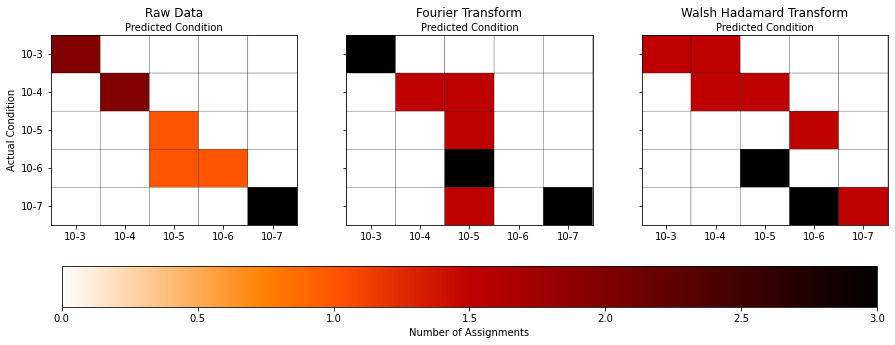

In [17]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMSC, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');